# Clustering 3K PBMCs with scVI and ScanPy

Disclaimer: some of the code in this notebook was taken from Scanpy's Clustering tutorial (https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) which is itself based on SEURAT's clustering tutorial in R.

This notebook is designed as a demonstration of scVI's potency on the tasks considered in the Scanpy PBMC 3K Clustering notebook.
In order to do so, we follow the same workflow adopted by scanpy in their clustering tutorial while performing the analysis using scVI as often as possible.
Specifically, we use scVI's latent representation and differential expression analysis (which computes a Bayes Factor on imputed values). 
For visualisation, pre-processing and for some canonical analysis, we use the Scanpy package directly.

When useful, we provide high-level wrappers around scVI's analysis tools. These functions are designed to make standard use of scVI as easy as possible.
For specific use cases, we encourage the reader to take a closer look at those functions and modify them according to their needs.

In [ ]:
# If running in Colab, navigate to Runtime -> Change runtime type
# and ensure you're using a Python 3 runtime with GPU hardware accelerator
# installation in Colab can take several minutes

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yoseflab/scvi/blob/dataset_refactor/tests/notebooks/scanpy_pbmc3k.ipynb)

## Colab and automated testing configuration

In [1]:
def allow_notebook_for_test():
    print("Testing the scanpy pbmc3k notebook")

import sys, os

n_epochs_all = None
test_mode = False
show_plot = True

def if_not_test_else(x, y):
    if not test_mode:
        return x
    else:
        return y

IN_COLAB = "google.colab" in sys.modules

show_plot = True
test_mode = False
n_epochs_all = None
save_path = "data/"

if not test_mode and not IN_COLAB:
    save_path = "../../data"

if IN_COLAB:
    !pip install --quiet git+https://github.com/yoseflab/scvi@dataset_refactor#egg=scvi[notebooks]

     |████████████████████████████████| 51kB 2.8MB/s 
     |████████████████████████████████| 112kB 12.1MB/s 
     |████████████████████████████████| 122kB 36.0MB/s 
     |████████████████████████████████| 7.2MB 32.2MB/s 
     |████████████████████████████████| 4.3MB 42.6MB/s 
     |████████████████████████████████| 2.2MB 39.7MB/s 
     |████████████████████████████████| 2.4MB 39.4MB/s 
     |████████████████████████████████| 3.2MB 44.1MB/s 
     |████████████████████████████████| 8.7MB 27.2MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 51kB 3.6MB/s 


## Initialization

In [2]:
download_data = False
if IN_COLAB or download_data:
    !mkdir data
    !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
    !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

--2020-07-21 22:09:44--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2020-07-21 22:09:44--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  --.-KB/s    in 0.1s    

2020-07-21 22:09:44 (54.0 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matric

In [3]:
# Seed for reproducibility
import torch
import numpy as np
import pandas as pd
import scanpy as sc
from typing import Tuple

# scVI imports
import scvi
from scvi.inference import UnsupervisedTrainer
from scvi.models.vae import VAE

torch.manual_seed(0)
np.random.seed(0)
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [4]:
if not test_mode:
    sc.settings.set_figure_params(dpi=60)
    %matplotlib inline

In [5]:
# Load the data
adata = sc.read_10x_mtx(
    os.path.join(
        save_path, "filtered_gene_bc_matrices/hg19/"
    ),  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
)
adata.var_names_make_unique()

## Preprocessing

In the following section, we reproduce the preprocessing steps adopted in the scanpy notebook. 


Basic filtering: we remove cells with a low number of genes expressed and genes which are expressed in a low number of cells.

In [6]:
min_genes = if_not_test_else(200, 0)
min_cells = if_not_test_else(3, 0)

In [7]:
sc.settings.verbosity = 2
sc.pp.filter_cells(adata, min_genes=min_genes)
sc.pp.filter_genes(adata, min_cells=min_cells)
sc.pp.filter_cells(adata, min_genes=1)

filtered out 19024 genes that are detected in less than 3 cells


As in the scanpy notebook, we then look for high levels of mitochondrial genes and high number of expressed genes which are indicators of poor quality cells.

In [8]:
mito_genes = adata.var_names.str.startswith("MT-")
adata.obs["percent_mito"] = (
    np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
)
adata.obs["n_counts"] = adata.X.sum(axis=1).A1

In [9]:
adata = adata[adata.obs["n_genes"] < 2500, :]
adata = adata[adata.obs["percent_mito"] < 0.05, :]

## scVI uses non normalized data so we keep the original data in a separate `AnnData` layer, then the normalization steps are performed

#####  Normalization and more filtering

We only keep highly variable genes

In [10]:
adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)


min_mean = if_not_test_else(0.0125, -np.inf)
max_mean = if_not_test_else(3, np.inf)
min_disp = if_not_test_else(0.5, -np.inf)
max_disp = if_not_test_else(None, np.inf)

sc.pp.highly_variable_genes(
    adata,
    min_mean=min_mean,
    max_mean=max_mean,
    min_disp=min_disp,
    max_disp=max_disp
)

highly_variable_genes = adata.var["highly_variable"]
adata = adata[:, highly_variable_genes]

adata.raw = adata

sc.pp.regress_out(adata, ["n_counts", "percent_mito"])
sc.pp.scale(adata, max_value=10)

print("{} highly variable genes".format(highly_variable_genes.sum()))

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


    finished (0:00:07)
1838 highly variable genes


## Setup anndata object for scVI

In [11]:
scvi.dataset.setup_anndata(adata, X_layers_key="counts")

[2020-07-21 22:10:07,031] INFO - scvi.dataset._anndata | Using data from adata.layers["counts"]
[2020-07-21 22:10:07,032] INFO - scvi.dataset._anndata | No batch_key inputted, assuming all cells are same batch
[2020-07-21 22:10:07,038] INFO - scvi.dataset._anndata | No label_key inputted, assuming all cells have same label
[2020-07-21 22:10:07,042] INFO - scvi.dataset._anndata | Computing library size prior per batch
[2020-07-21 22:10:07,058] INFO - scvi.dataset._anndata | Successfully registered anndata object containing 2638 cells, 1838 genes, and 1 batches 
Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']


## Compute the scVI latent space

Below we provide then use a wrapper function designed to compute scVI's latent representation of the non-normalized data. Specifically, we train scVI's VAE, compute and store the latent representation then return the posterior which will later be used for further inference.

In [12]:
def compute_scvi_latent(
    adata: sc.AnnData,
    n_latent: int = 5,
    n_epochs: int = 100,
    lr: float = 1e-3,
    use_batches: bool = False,
    use_cuda: bool = False,
) -> Tuple[scvi.inference.Posterior, np.ndarray]:
    """Train and return a scVI model and sample a latent space
    
    :param adata: sc.AnnData object non-normalized
    :param n_latent: dimension of the latent space
    :param n_epochs: number of training epochs
    :param lr: learning rate
    :param use_batches
    :param use_cuda
    :return: (scvi.Posterior, latent_space)
    """
    # Convert easily to scvi dataset
    stats = adata.uns["scvi_summary_stats"]

    # Train a model
    vae = VAE(
        stats["n_genes"],
        n_batch=stats["n_batch"] * use_batches,
        n_latent=n_latent,
    )
    trainer = UnsupervisedTrainer(vae, adata, train_size=1.0, use_cuda=use_cuda)
    trainer.train(n_epochs=n_epochs, lr=lr)
    ####

    # Extract latent space
    posterior = trainer.create_posterior(
        trainer.model, adata, indices=np.arange(len(adata))
    ).sequential()

    latent, _, _ = posterior.get_latent()

    return posterior, latent

In [13]:
n_epochs = 400 if n_epochs_all is None else n_epochs_all

# use_cuda to use GPU
use_cuda = True if IN_COLAB else False

scvi_posterior, scvi_latent = compute_scvi_latent(
    adata, n_epochs=n_epochs, n_latent=10, use_cuda=use_cuda
)
adata.obsm["X_scvi"] = scvi_latent

# store scvi imputed expression
scale = scvi_posterior.get_sample_scale()
for _ in range(9):
    scale += scvi_posterior.get_sample_scale()
scale /= 10

for gene, gene_scale in zip(adata.var.index, np.squeeze(scale).T):
    adata.obs["scale_" + gene] = gene_scale

[2020-07-21 22:10:07,262] INFO - scvi.inference.inference | KL warmup for 400 epochs
training: 100%|██████████| 400/400 [11:59<00:00,  1.80s/it]


## Principal component analysis to reproduce ScanPy results and compare them against scVI's

Below, we reproduce exactly scanpy's PCA on normalized data.

In [14]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


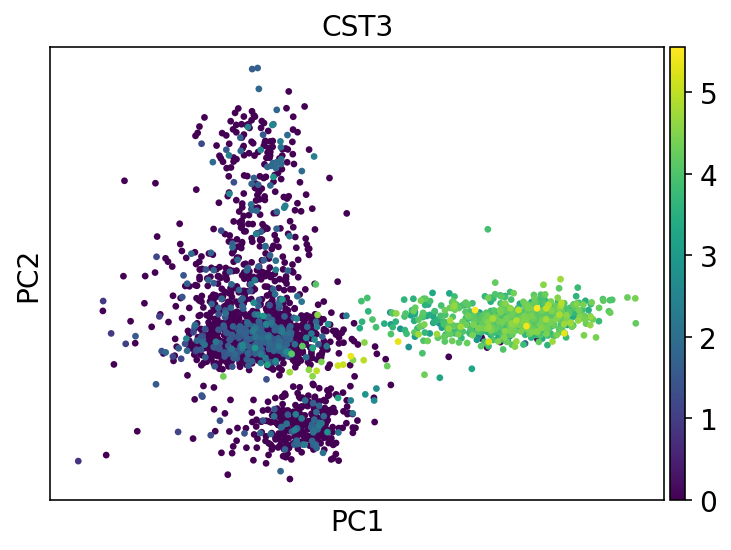

In [15]:
sc.pl.pca(adata, color="CST3", show=show_plot)

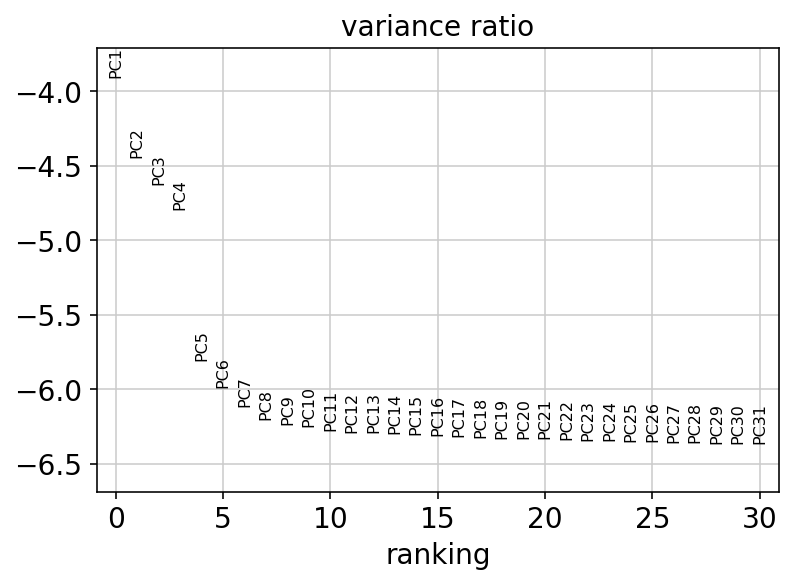

In [16]:
sc.pl.pca_variance_ratio(adata, log=True, show=show_plot)

## Computing, embedding and clustering the neighborhood graph

The Scanpy API computes a neighborhood graph with `sc.pp.neighbors` which can be called to work on a specific representation `use_rep='your rep'`.
Once the neighbors graph has been computed, all Scanpy algorithms working on it can be called as usual (that is *louvain*, *paga*, *umap* ...)

### Using PCA representation (Scanpy tutorial)

In [17]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata, key_added="leiden_pca")
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:03)
running Leiden clustering
    finished (0:00:00)
computing UMAP
    finished (0:00:07)


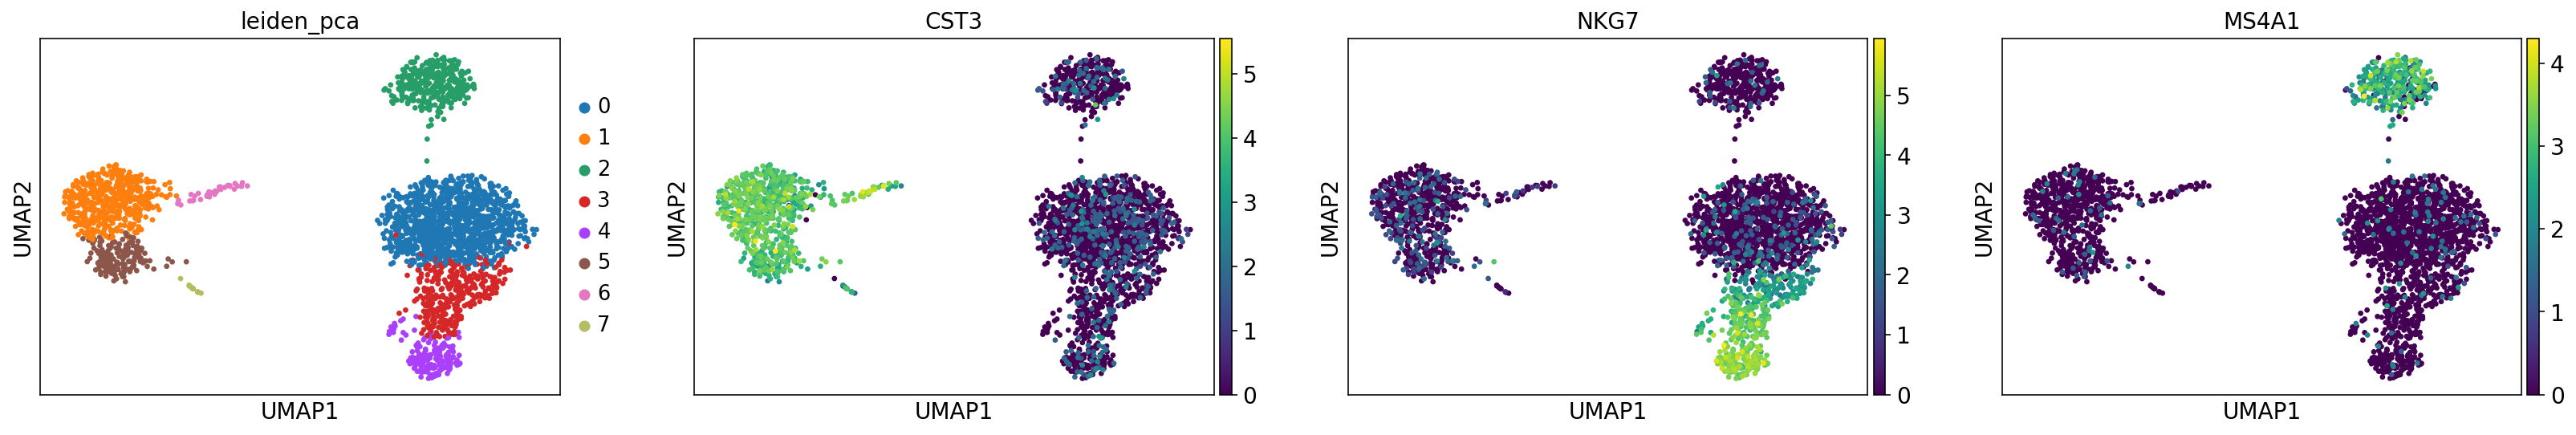

In [18]:
sc.pl.umap(adata, color=["leiden_pca", "CST3", "NKG7", "MS4A1"], ncols=4, show=show_plot)

### Using scVI latent space representation

In [19]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40, use_rep="X_scvi")
sc.tl.umap(adata)

computing neighbors
    finished (0:00:00)
computing UMAP
    finished (0:00:08)


In [20]:
sc.tl.leiden(adata, key_added="leiden_scvi", resolution=0.8)

running Leiden clustering
    finished (0:00:00)


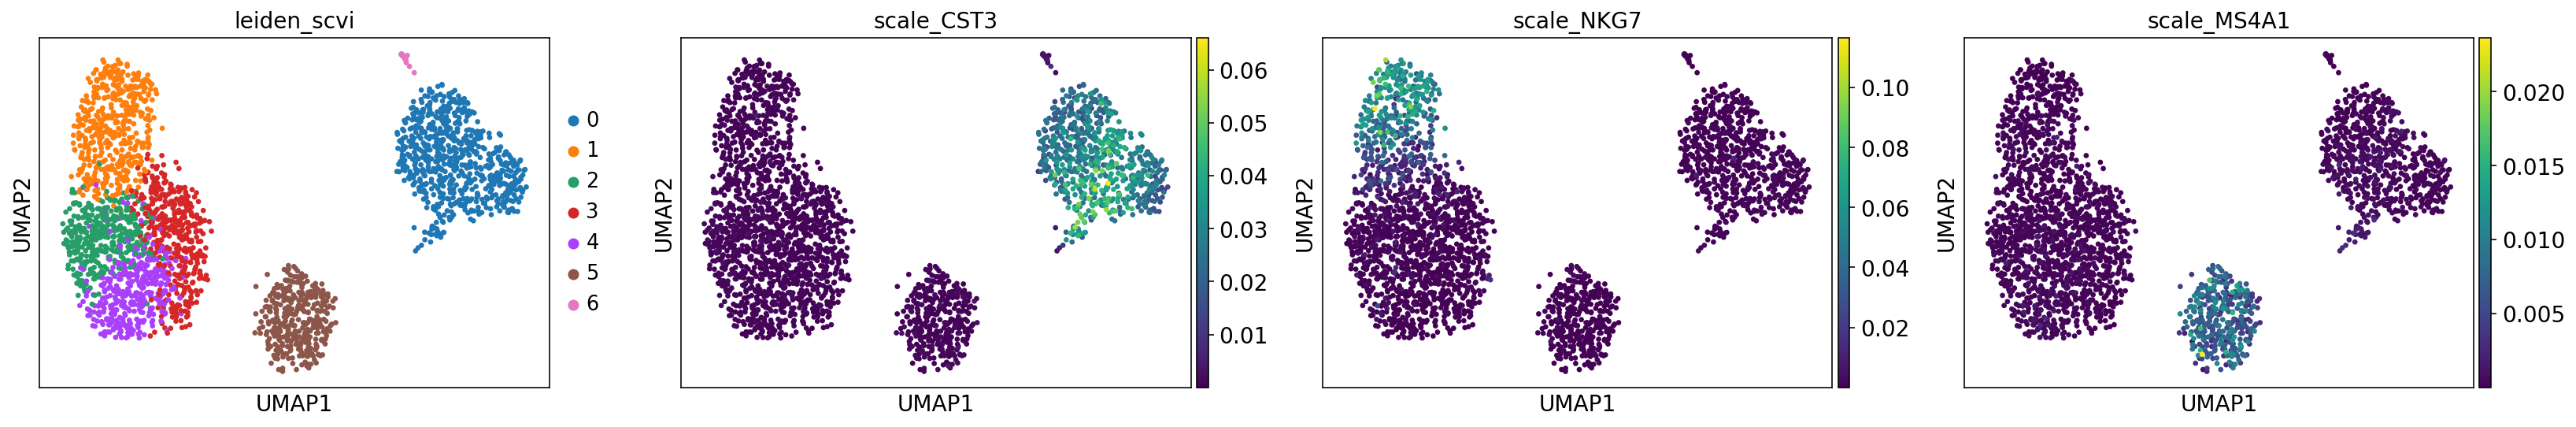

In [21]:
# use scVI imputed values for plotting
sc.pl.umap(adata, color=["leiden_scvi", "scale_CST3", "scale_NKG7", "scale_MS4A1"], ncols=4, show=show_plot)

## Finding marker genes

ScanPy tries to determine marker genes using a *t-test* and a *Wilcoxon* test.

For the same task, from scVI's trained VAE model we can sample the gene expression rate for each gene in each cell. For the two populations of interest, we can then randomly sample pairs of cells, one from each population to compare their expression rate for a gene. The degree of **differential expression** is measured by logit($\frac{p}{1-p}$) (Bayes Factor) where $p$ is the probability of a cell from population $A$ having a higher expression than a cell from population $B$ (in "change" mode higher expression refers to the log fold change of expression being greater than $\delta = 0.5$).

Below, we provide a wrapper around scVI's differential expression process. Specifically, it computes the average of the Bayes factor where population $A$ covers each cluster in `adata.obs[label_name]` and is compared with the aggregate formed by all the other clusters.

In [22]:
def rank_genes_groups_bayes(
    adata: sc.AnnData,
    scvi_posterior: scvi.inference.Posterior,
    n_samples: int = 5000,
    M_permutation: int = 10000,
    n_genes: int = 25,
    label_name: str = "leiden_scvi",
    mode: str = "vanilla"
) -> pd.DataFrame:
    """
    Rank genes for characterizing groups. 
    Computes Bayes factor for each cluster against the others to test for differential expression.
    See Nature article (https://rdcu.be/bdHYQ)

    :param adata: sc.AnnData object non-normalized
    :param scvi_posterior: 
    :param n_samples: 
    :param M_permutation: 
    :param n_genes: 
    :param label_name: The groups tested are taken from adata.obs[label_name] which can be computed 
                       using clustering like Louvain (Ex: sc.tl.louvain(adata, key_added=label_name) )
    :return: Summary of Bayes factor per gene, per cluster
    """

    # Call scvi function
    per_cluster_de, cluster_id = scvi_posterior.one_vs_all_degenes(
        cell_labels=np.asarray(adata.obs[label_name].values).astype(int).ravel(),
        min_cells=1,
        n_samples=n_samples,
        M_permutation=M_permutation,
        mode=mode
    )

    # convert to ScanPy format -- this is just about feeding scvi results into a format readable by ScanPy
    markers = []
    scores = []
    names = []
    for i, x in enumerate(per_cluster_de):
        subset_de = x[:n_genes]
        markers.append(subset_de)
        scores.append(tuple(subset_de["bayes_factor"].values))
        names.append(tuple(subset_de.index.values))

    markers = pd.concat(markers)
    dtypes_scores = [(str(i), "<f4") for i in range(len(scores))]
    dtypes_names = [(str(i), "<U50") for i in range(len(names))]
    scores = np.array([tuple(row) for row in np.array(scores).T], dtype=dtypes_scores)
    scores = scores.view(np.recarray)
    names = np.array([tuple(row) for row in np.array(names).T], dtype=dtypes_names)
    names = names.view(np.recarray)

    adata.uns["rank_genes_groups_scvi"] = {
        "params": {
            "groupby": "",
            "reference": "rest",
            "method": "",
            "use_raw": True,
            "corr_method": "",
        },
        "scores": scores,
        "names": names,
    }
    return markers

### Use a t-test on scvi_clusters like in the ScanPy tutorial

ranking genes
    finished (0:00:00)
ranking genes
    finished (0:00:00)


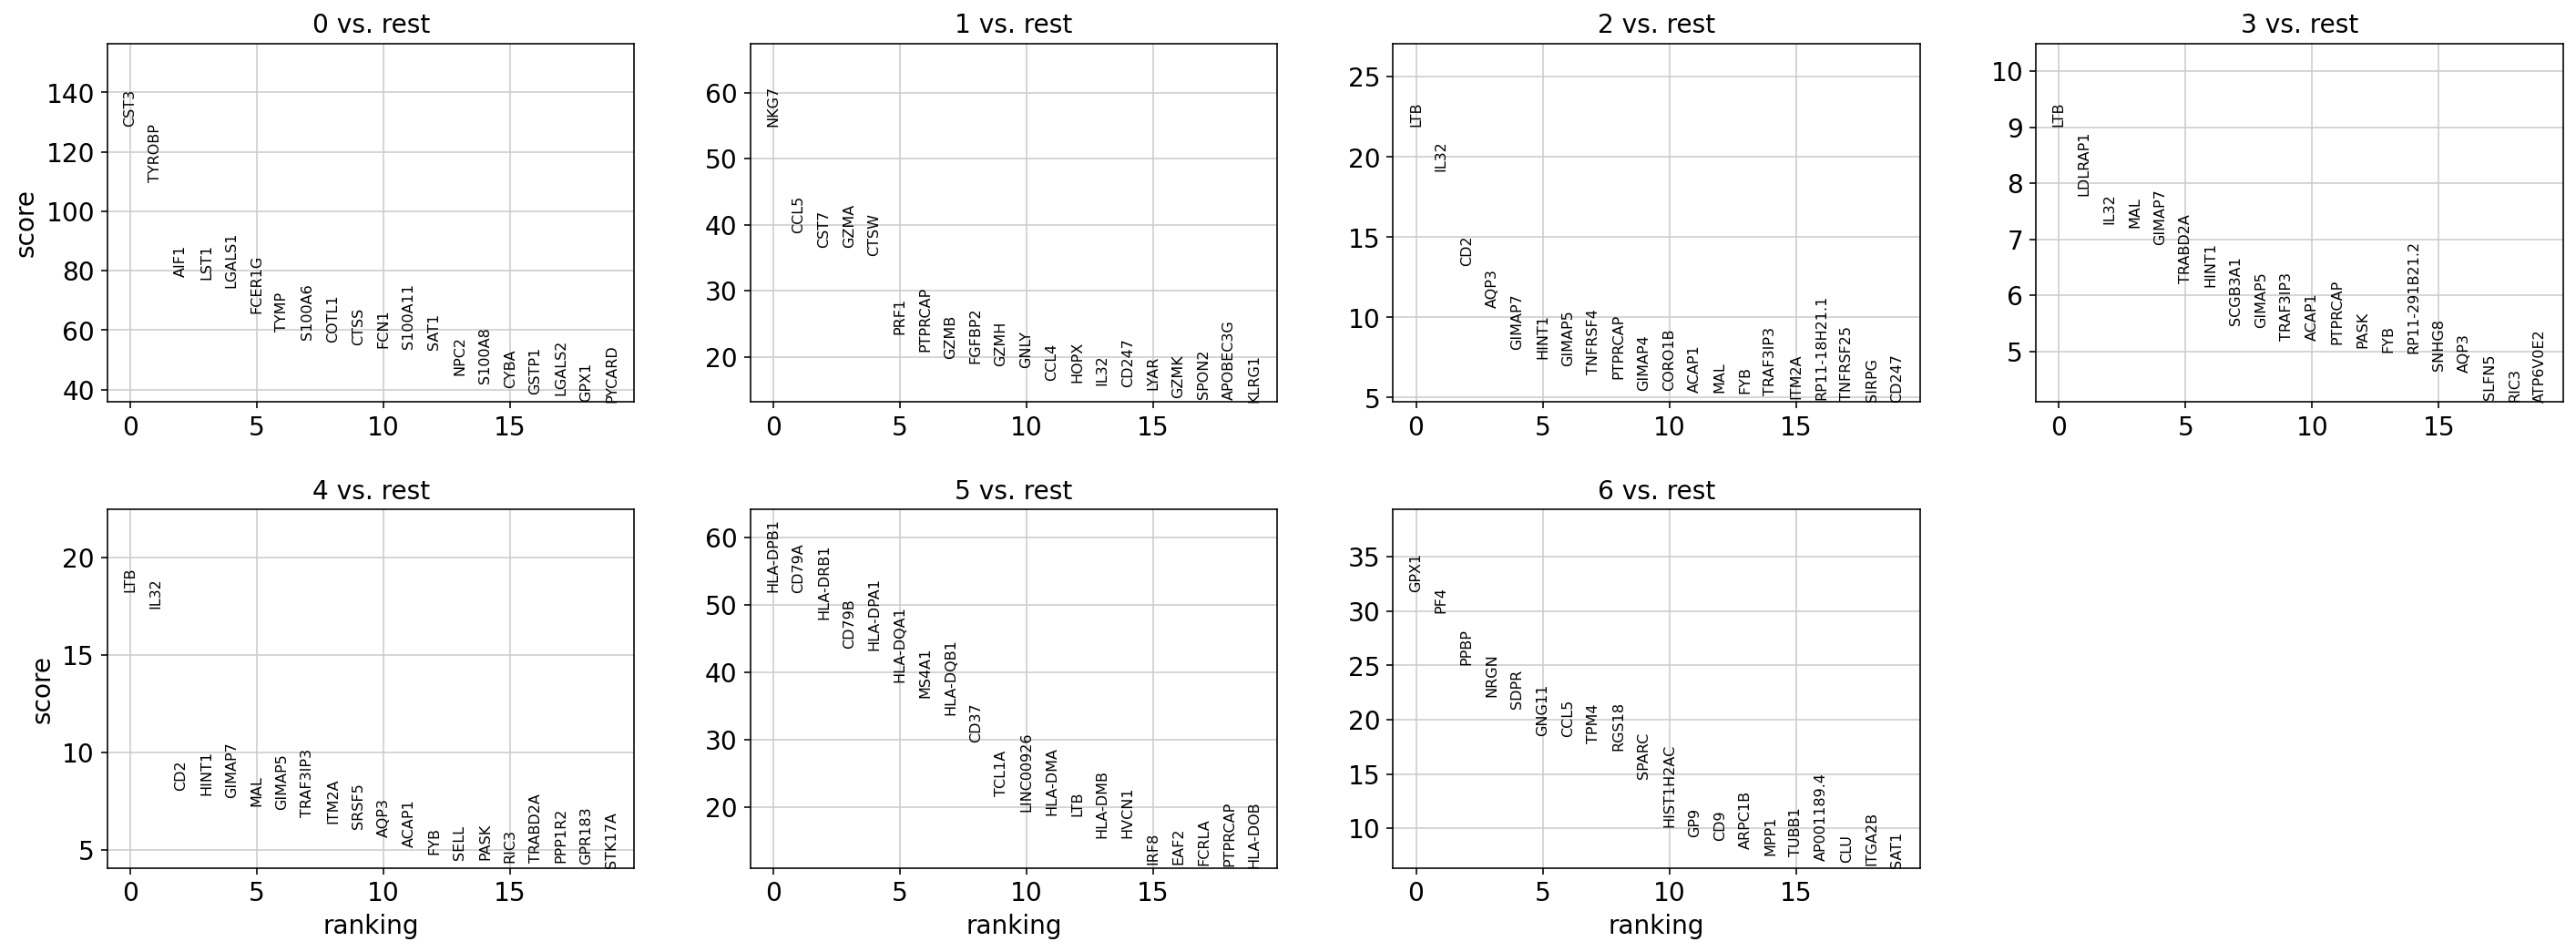

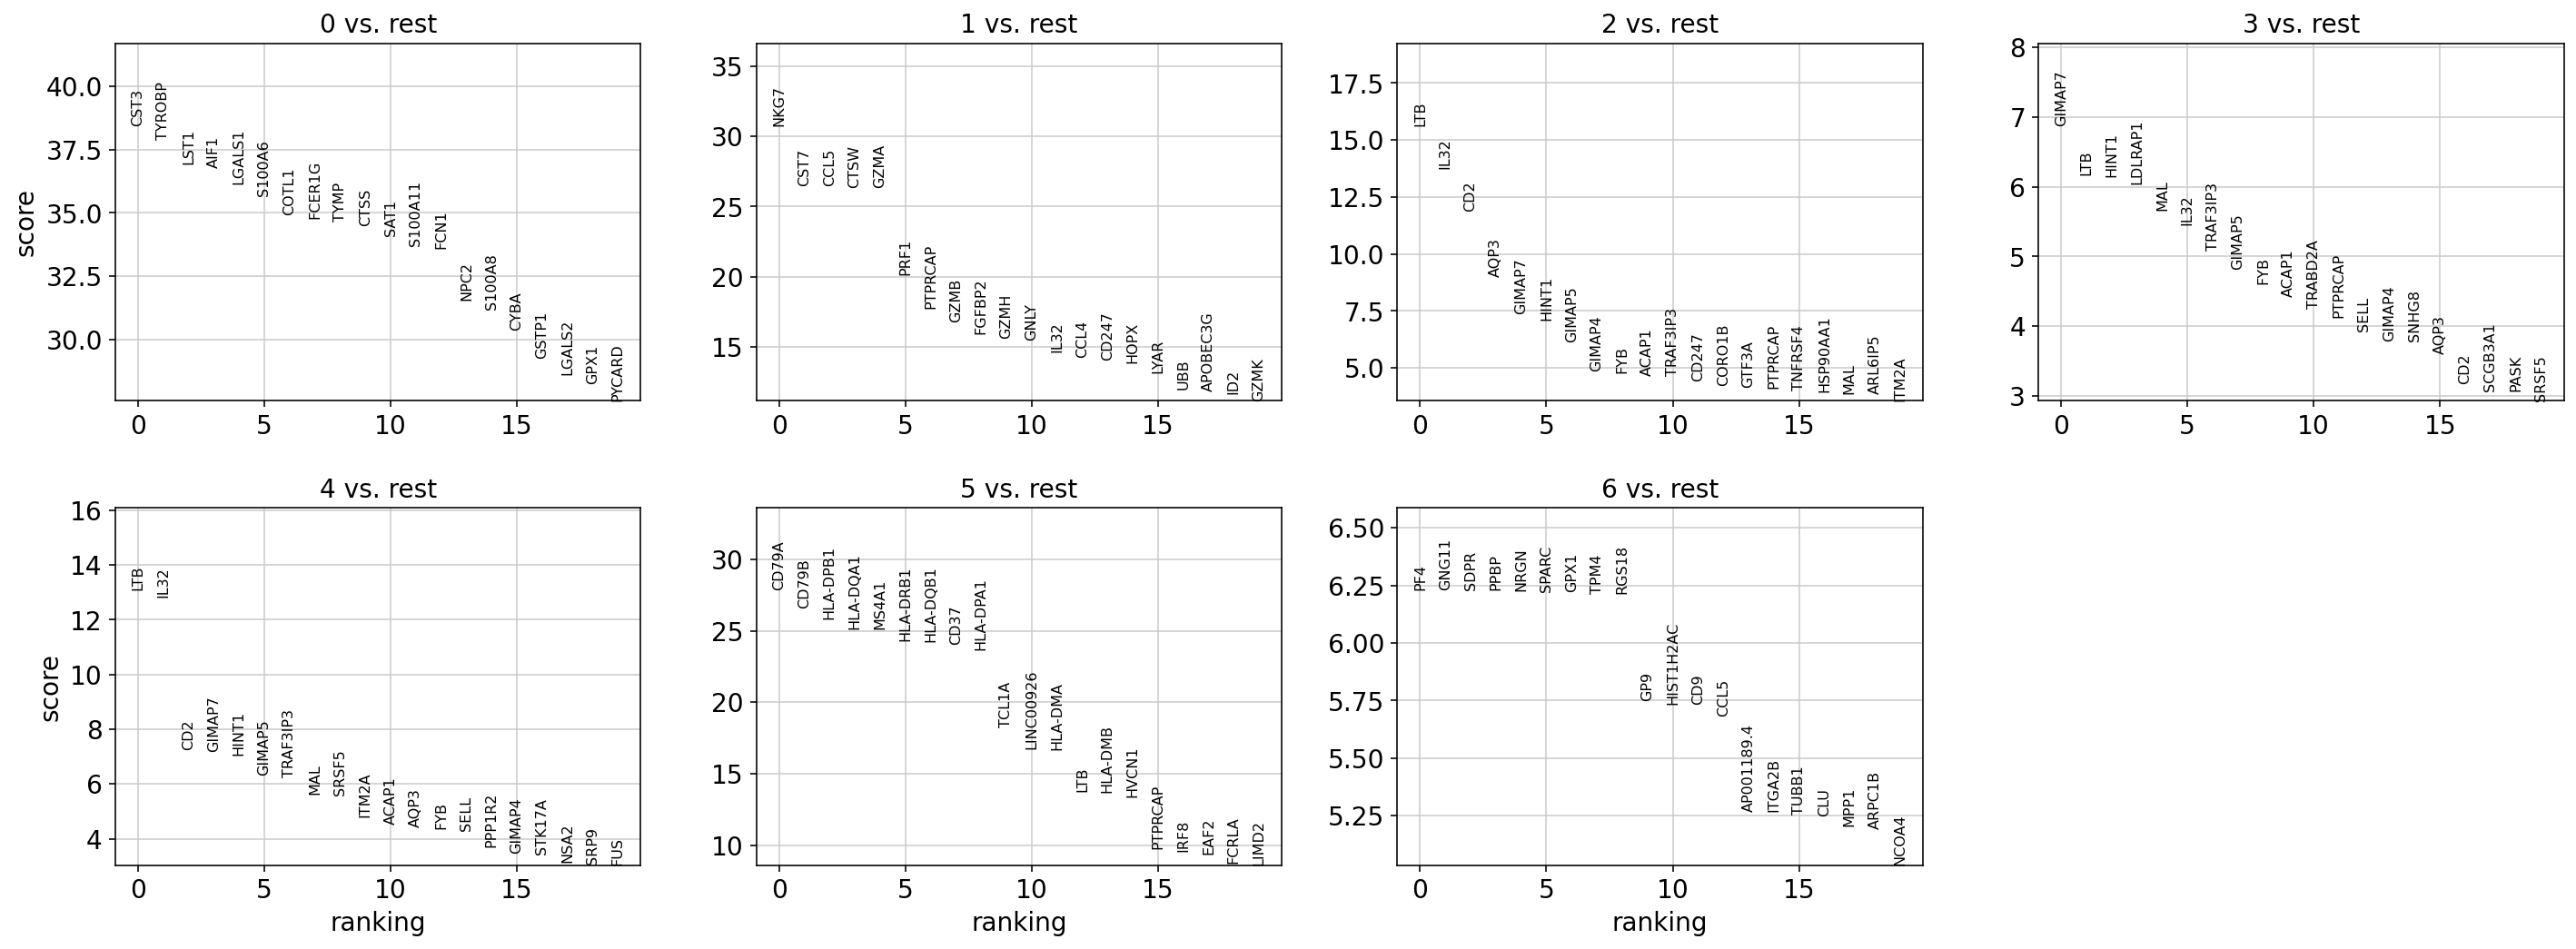

In [23]:
n_genes = 20
sc.tl.rank_genes_groups(
    adata,
    "leiden_scvi",
    method="t-test",
    use_raw=True,
    key_added="rank_genes_groups_ttest",
    n_genes=n_genes,
)
sc.tl.rank_genes_groups(
    adata,
    "leiden_scvi",
    method="wilcoxon",
    use_raw=True,
    key_added="rank_genes_groups_wilcox",
    n_genes=n_genes,
)
sc.pl.rank_genes_groups(
    adata, key="rank_genes_groups_ttest", sharey=False, n_genes=n_genes, show=show_plot
)
sc.pl.rank_genes_groups(
    adata, key="rank_genes_groups_wilcox", sharey=False, n_genes=n_genes, show=show_plot
)

### Use differential expression from the scVI posterior

100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


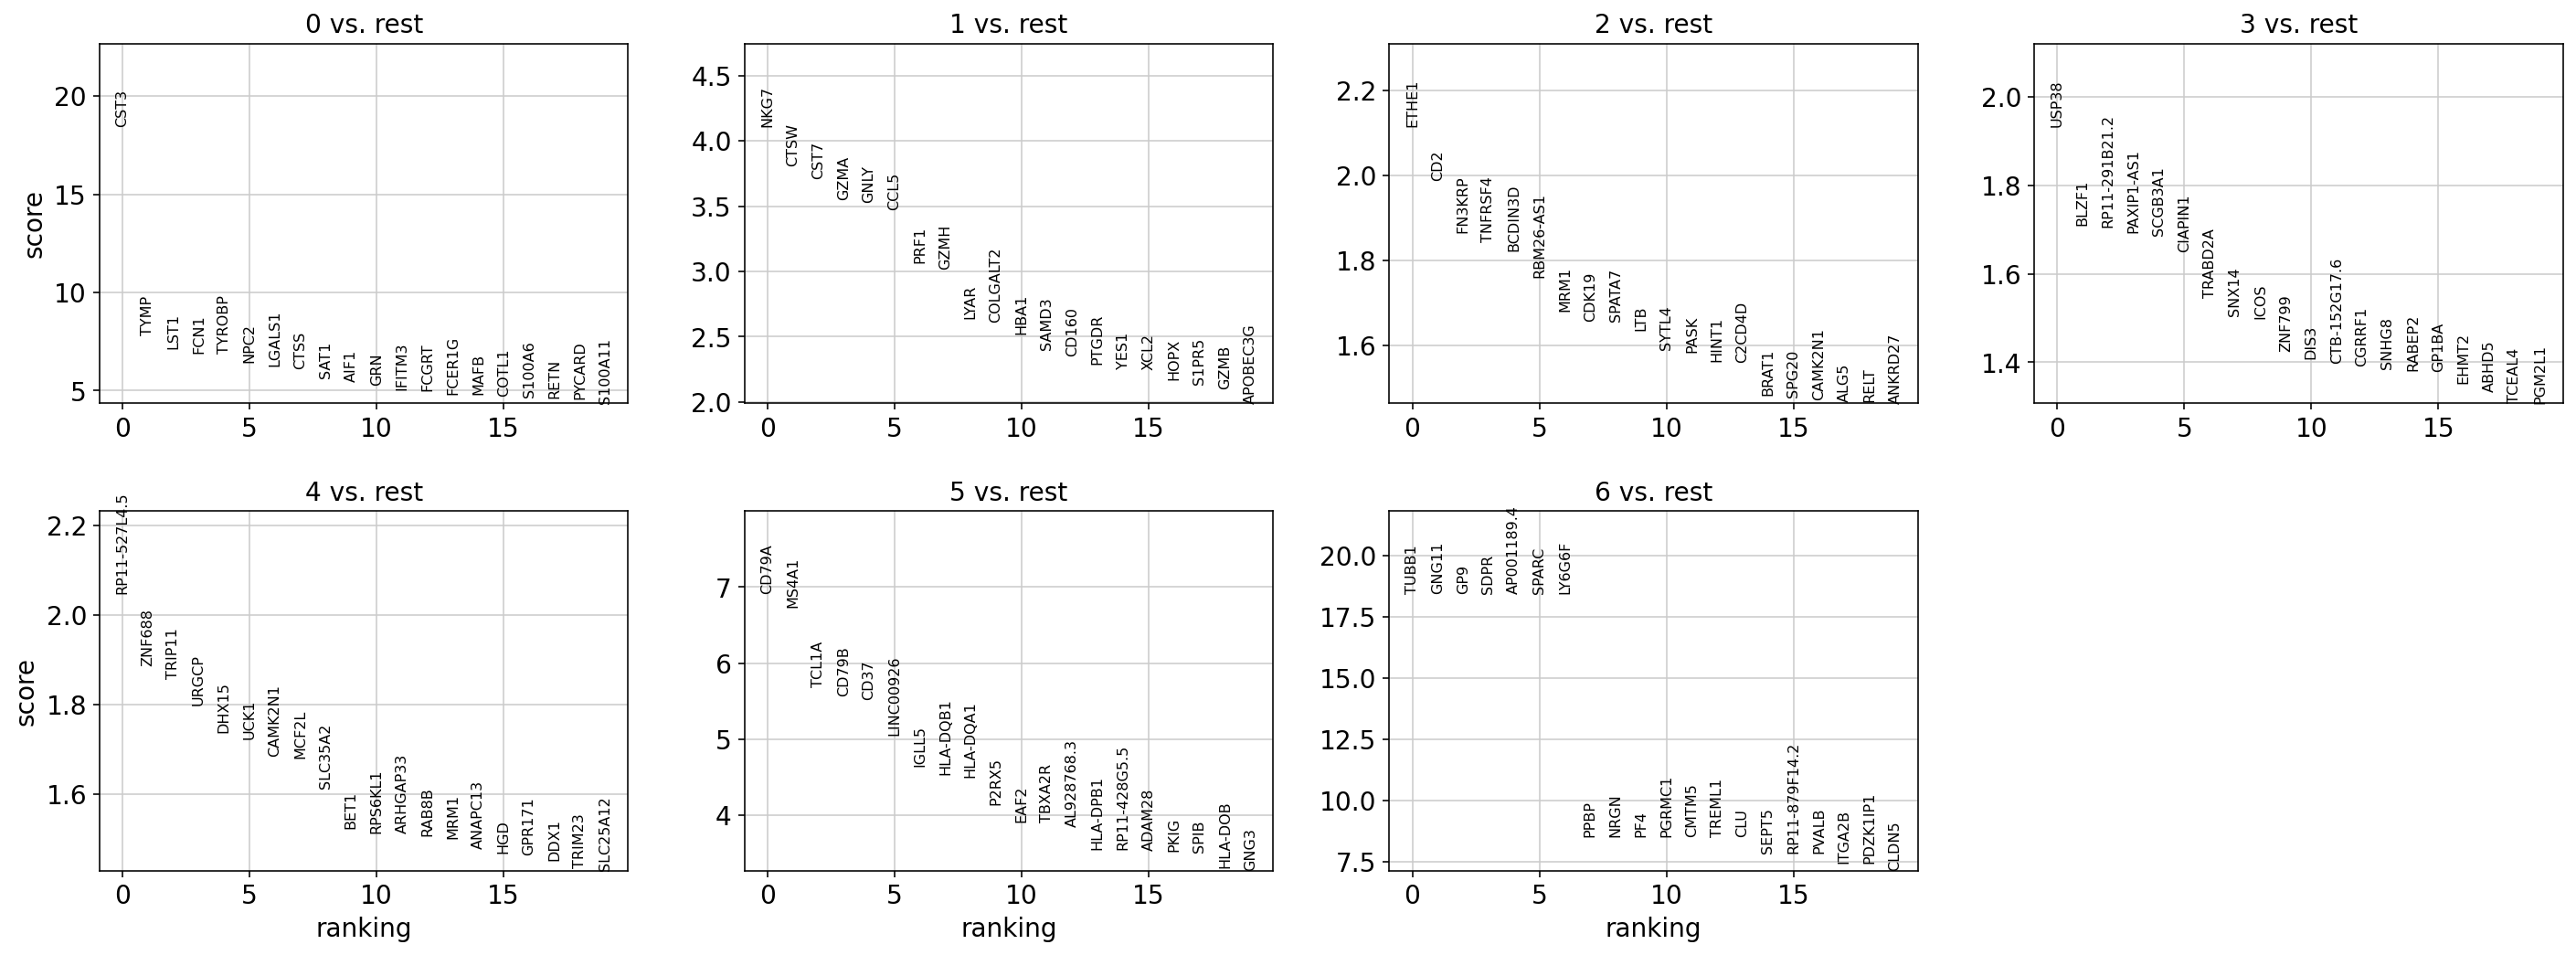

In [24]:
rank_genes_groups_bayes(
    adata, scvi_posterior, label_name="leiden_scvi", n_genes=n_genes
)
sc.pl.rank_genes_groups(
    adata, key="rank_genes_groups_scvi", sharey=False, n_genes=n_genes, show=show_plot
)

### Measure similarity between *scVI differential expression*, *t-test* and *wilcoxon-test*

In [25]:
# We compute the rank of every gene to perform analysis after
all_genes = len(adata.var_names)

sc.tl.rank_genes_groups(adata, 'leiden_scvi', method='t-test',   use_raw=False, key_added='rank_genes_groups_ttest',  n_genes=all_genes)
sc.tl.rank_genes_groups(adata, 'leiden_scvi', method='wilcoxon', use_raw=False, key_added='rank_genes_groups_wilcox', n_genes=all_genes)
differential_expression = rank_genes_groups_bayes(adata, scvi_posterior, label_name='leiden_scvi', n_genes=all_genes)

ranking genes
    finished (0:00:00)
ranking genes


/usr/local/lib/python3.6/dist-packages/scanpy/tools/_rank_genes_groups.py:252: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished (0:00:00)


/usr/local/lib/python3.6/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))
100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


In [26]:
def ratio(A, B):
    A, B = set(A), set(B)
    return len(A.intersection(B)) / len(A) * 100

In [27]:
cluster_distrib = adata.obs.groupby("leiden_scvi").count()["n_genes"]

For each cluster, we compute the percentage of genes which are in the `n_genes` most expressed  genes of both Scanpy's and scVI's differential expression tests.

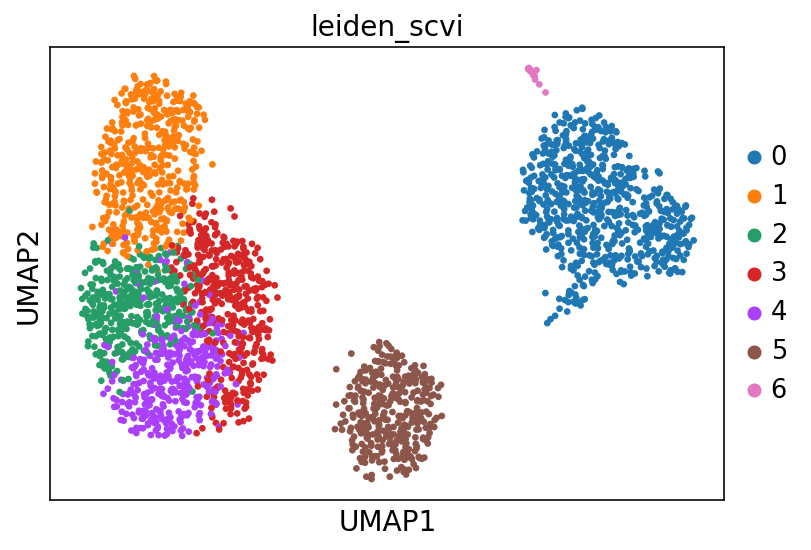

Cluster 0 (676 cells): t-test / wilcox 100.00 %  & t-test / scvi  76.00 %
Cluster 1 (447 cells): t-test / wilcox  64.00 %  & t-test / scvi  60.00 %
Cluster 2 (391 cells): t-test / wilcox  20.00 %  & t-test / scvi  24.00 %
Cluster 3 (388 cells): t-test / wilcox  60.00 %  & t-test / scvi  20.00 %
Cluster 4 (378 cells): t-test / wilcox   8.00 %  & t-test / scvi   0.00 %
Cluster 5 (345 cells): t-test / wilcox  64.00 %  & t-test / scvi  60.00 %
Cluster 6 (13 cells): t-test / wilcox  64.00 %  & t-test / scvi  56.00 %


In [28]:
n_genes = 25

sc.pl.umap(adata, color=["leiden_scvi"], ncols=1, show=show_plot)
for c in cluster_distrib.index:
    print(
        "Cluster %s (%d cells): t-test / wilcox %6.2f %%  & t-test / scvi %6.2f %%"
        % (
            c,
            cluster_distrib[c],
            ratio(
                adata.uns["rank_genes_groups_ttest"]["names"][c][:n_genes],
                adata.uns["rank_genes_groups_wilcox"]["names"][c][:n_genes],
            ),
            ratio(
                adata.uns["rank_genes_groups_ttest"]["names"][c][:n_genes],
                adata.uns["rank_genes_groups_scvi"]["names"][c][:n_genes],
            ),
        )
    )

## Plot px_scale for most expressed genes and less expressed genes by cluster

#### Most differentialy expressed genes

In [29]:
cluster_id = 2
n_best_genes = 10
gene_names = differential_expression[
    differential_expression["clusters"] == cluster_id
].index.tolist()[:n_best_genes]
gene_names

['ETHE1',
 'CD2',
 'FN3KRP',
 'BCDIN3D',
 'TNFRSF4',
 'CDK19',
 'MRM1',
 'RBM26-AS1',
 'SPATA7',
 'LTB']

Top genes for cluster 2


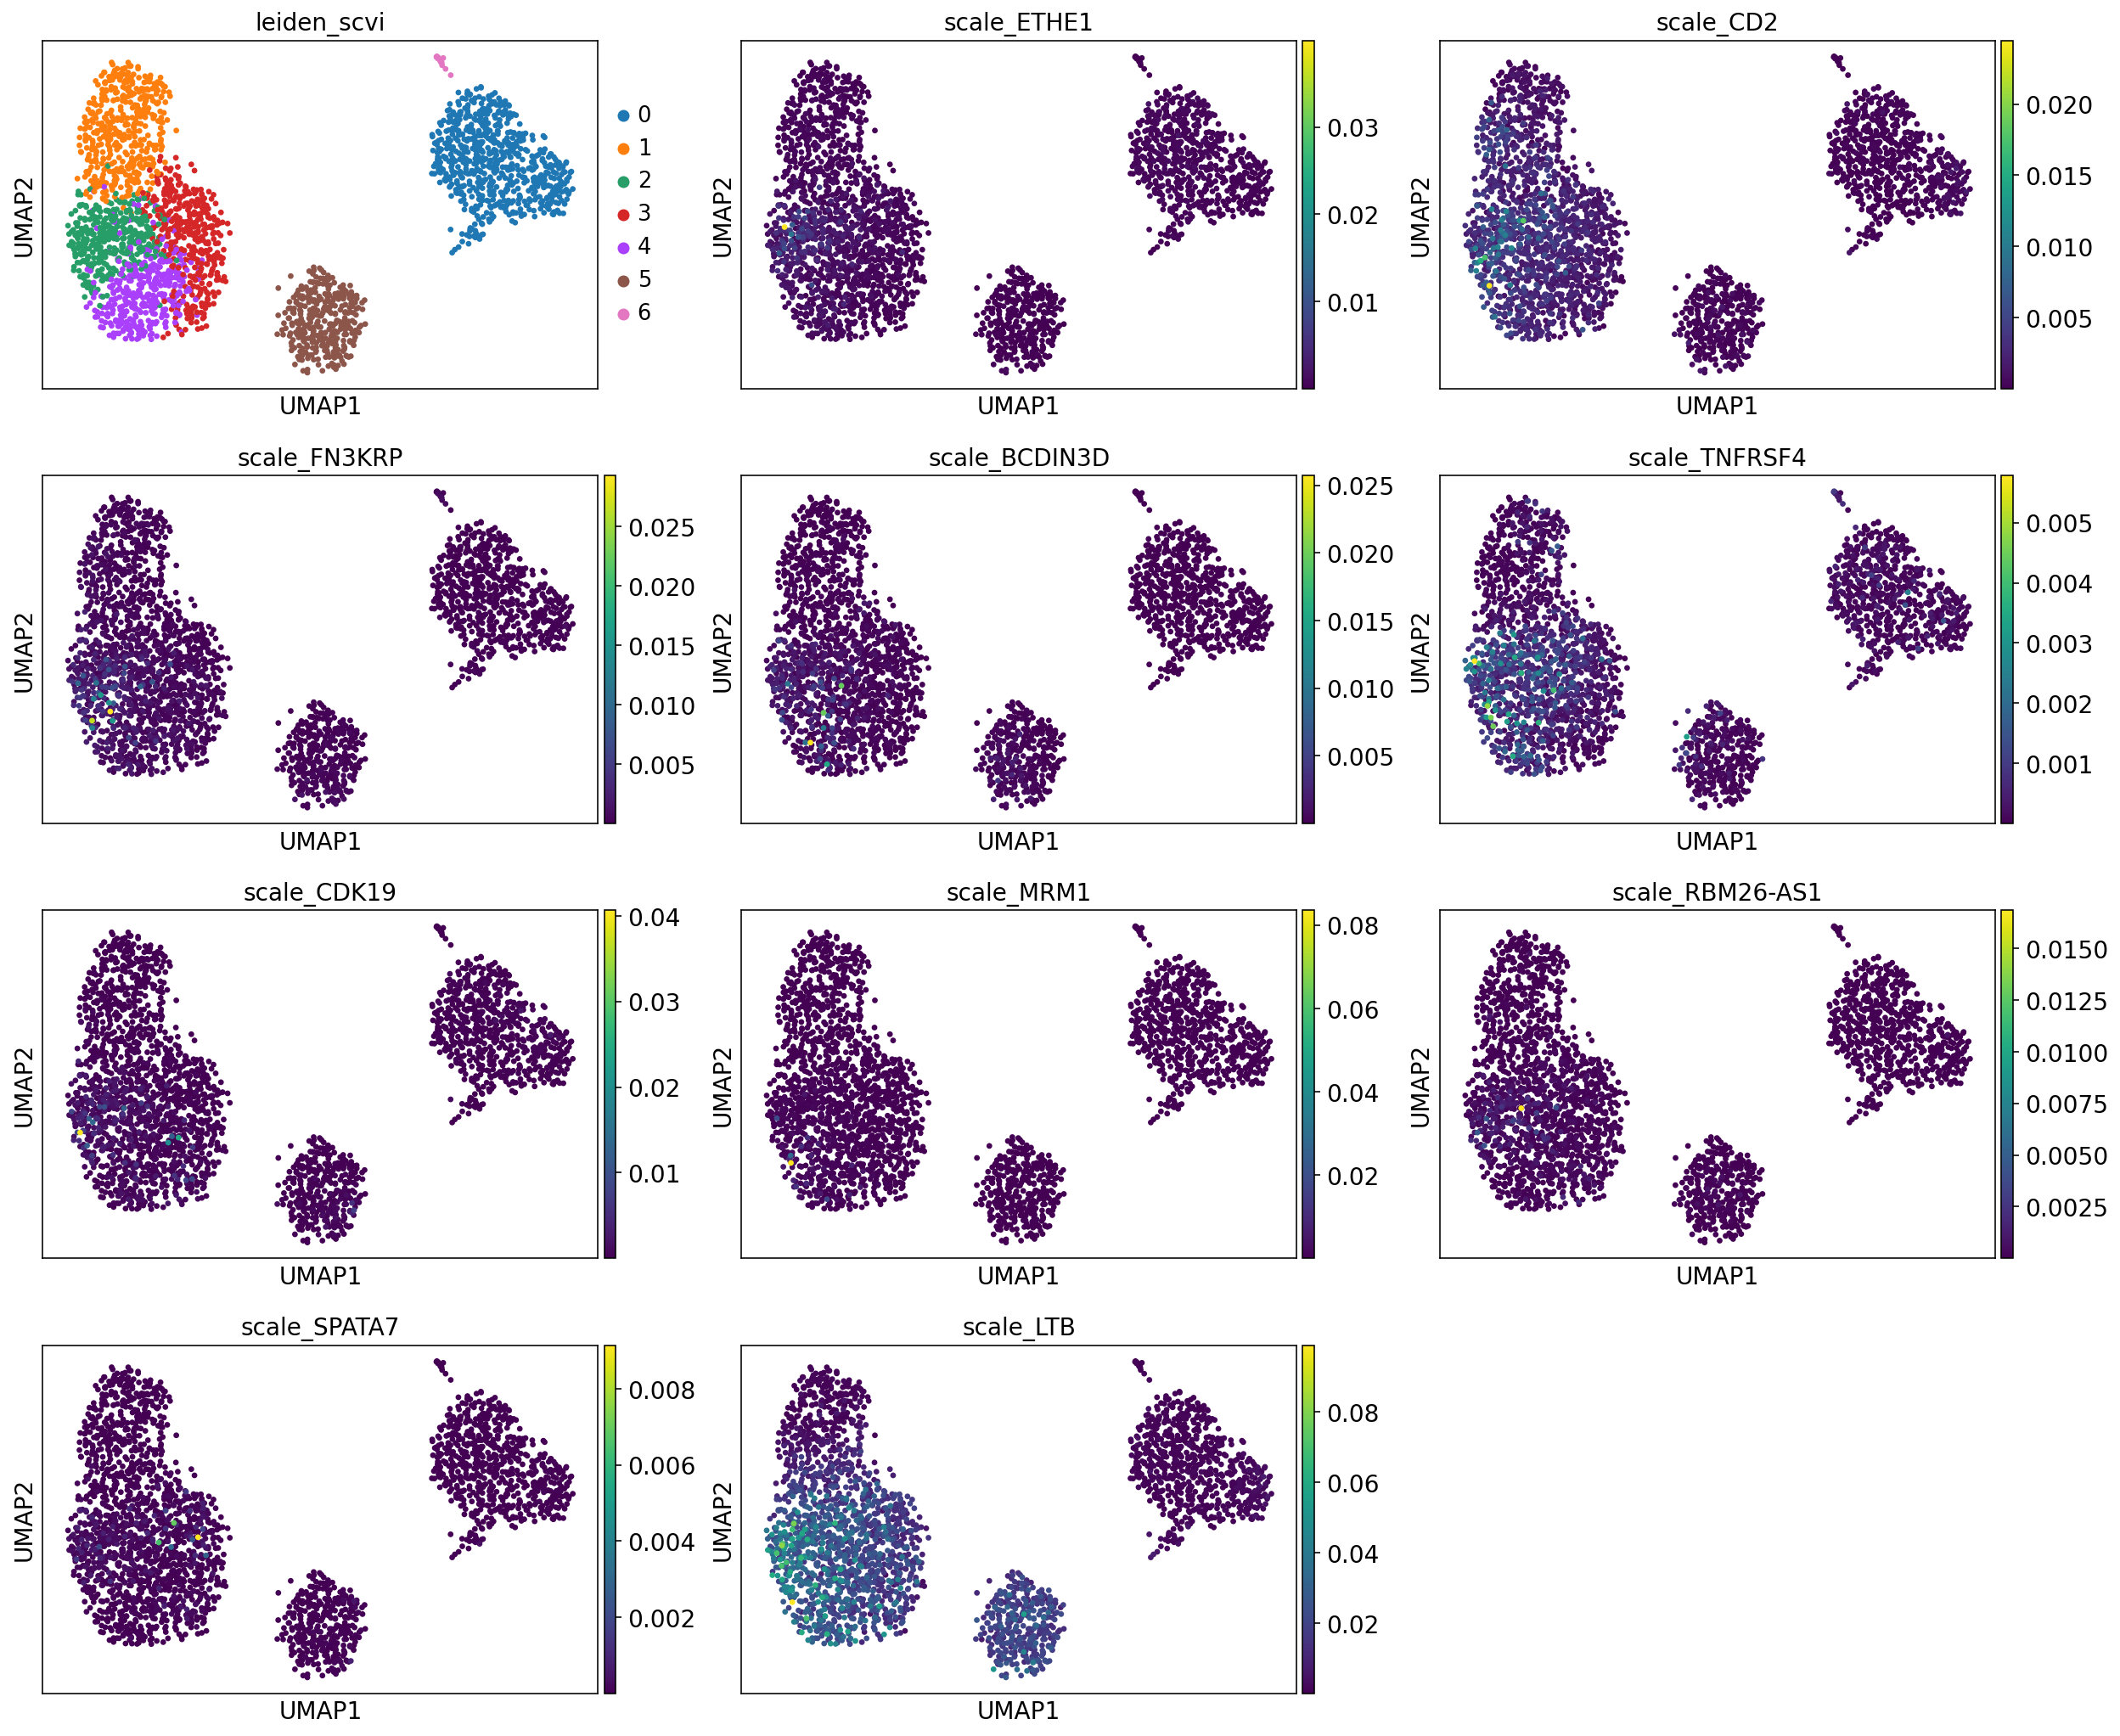

In [30]:
print("Top genes for cluster %d" % cluster_id)
sc.pl.umap(adata, color=["leiden_scvi"] + ["scale_{}".format(g) for g in gene_names], ncols=3, show=show_plot)

#### Less differentialy expressed genes

In [31]:
cluster_id = 2
n_best_genes = 10
gene_names = differential_expression[
    differential_expression["clusters"] == cluster_id
].index.tolist()[-n_best_genes:]
gene_names

['KIF3C',
 'TSPAN33',
 'GUCD1',
 'DNASE1L3',
 'ARHGAP24',
 'CCL3',
 'LAT2',
 'MMP9',
 'RP11-145M9.4',
 'PNOC']

Top down regulated genes for cluster 2


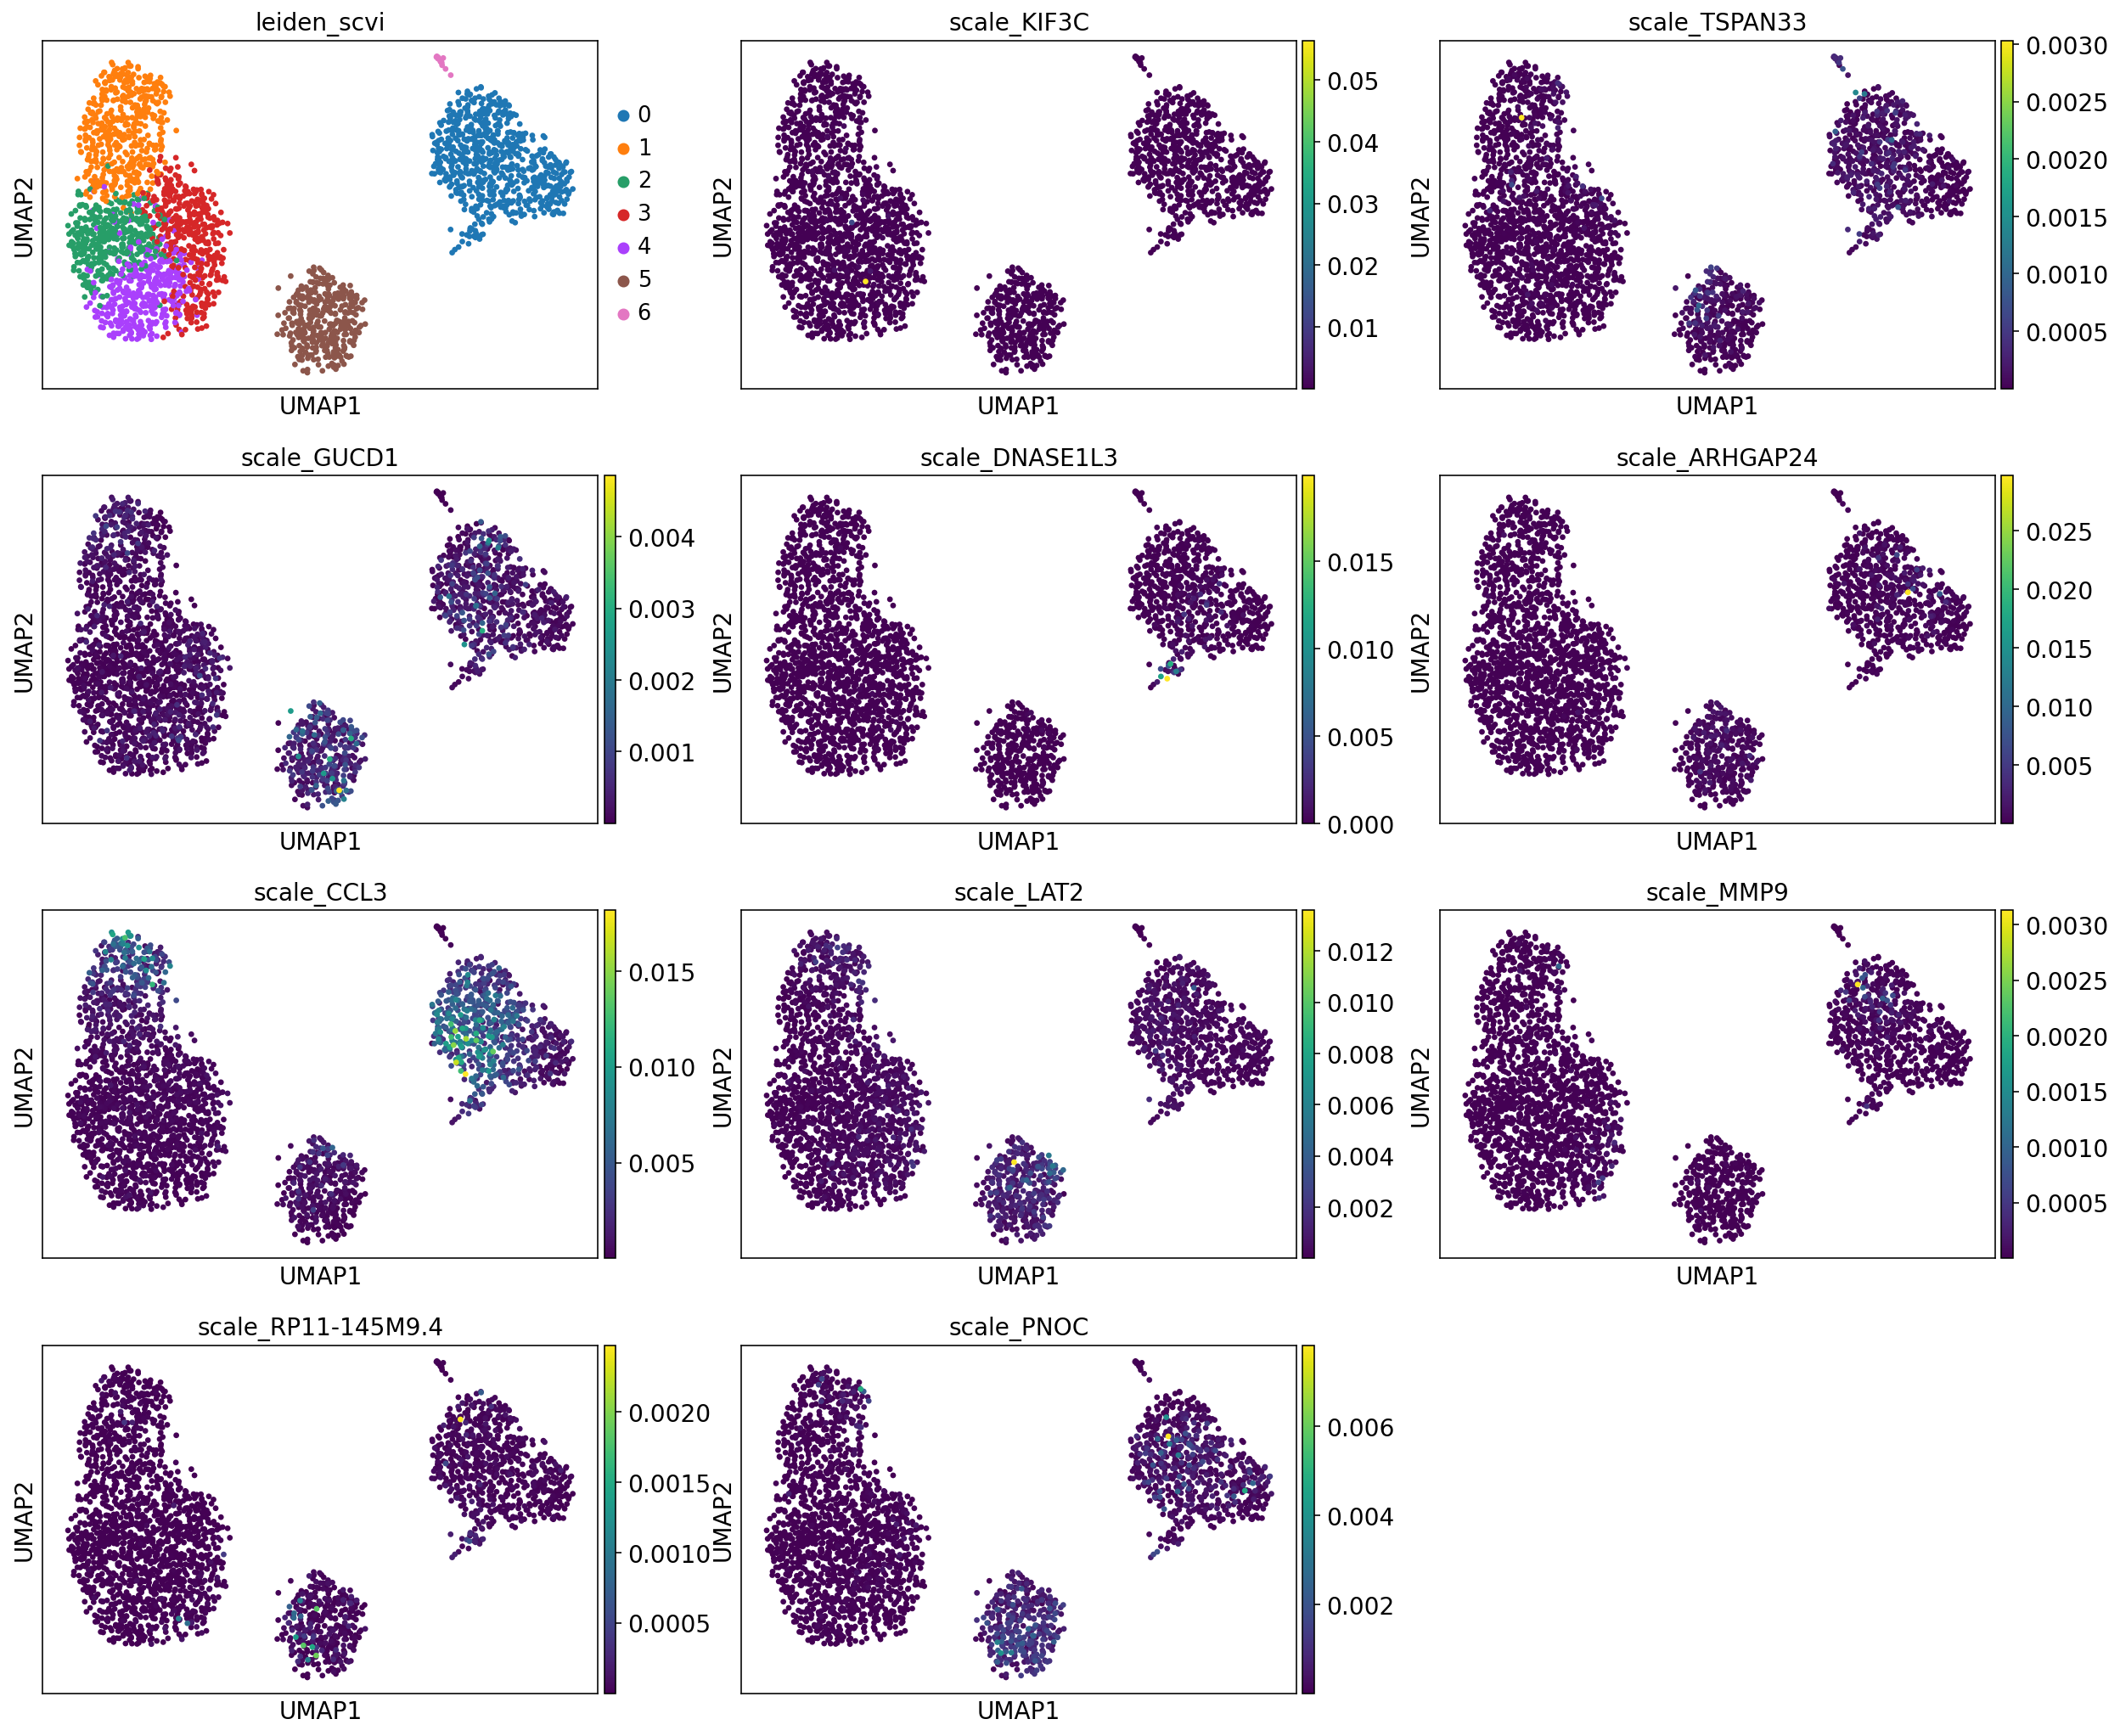

In [32]:
print("Top down regulated genes for cluster %d" % cluster_id)
sc.pl.umap(adata, color=["leiden_scvi"] + ["scale_{}".format(g) for g in gene_names], ncols=3, show=show_plot)

### Store differential expression scores

In [33]:
def store_de_scores(
    adata: sc.AnnData, differential_expression: pd.DataFrame, save_path: str = None
):
    """Creates, returns and writes a DataFrame with all the differential scores used in this notebook.
    
    Args:
        adata: scRNAseq dataset
        differential_expression: Pandas Dataframe containing the bayes factor for all genes and clusters
        save_path: file path for writing the resulting table

    Returns:
        pandas.DataFrame containing the scores of each differential expression test.

    """
    # get shapes for array initialisation
    n_genes_de = differential_expression[
        differential_expression["clusters"] == 0
    ].shape[0]
    all_genes = adata.shape[1]
    # check that all genes have been used
    if n_genes_de != all_genes:
        raise ValueError(
            "scvi differential expression has to have been run with n_genes=all_genes"
        )
    # get tests results from AnnData unstructured annotations
    rec_scores = []
    rec_names = []
    test_types = ["ttest", "wilcox"]
    for test_type in test_types:
        res = adata.uns["rank_genes_groups_" + test_type]
        rec_scores.append(res["scores"])
        rec_names.append(res["names"])
    # restrict scvi table to bayes factor
    res = differential_expression[["bayes_factor", "clusters"]]
    # for each cluster join then append all
    dfs_cluster = []
    groups = res.groupby("clusters")
    for cluster, df in groups:
        for rec_score, rec_name, test_type in zip(rec_scores, rec_names, test_types):
            temp = pd.DataFrame(
                rec_score[str(cluster)],
                index=rec_name[str(cluster)],
                columns=[test_type],
            )
            df = df.join(temp)
        dfs_cluster.append(df)
    res = pd.concat(dfs_cluster)
    if save_path:
        res.to_csv(save_path)
    return res

In [34]:
de_table = store_de_scores(adata, differential_expression, save_path=None)
de_table.head()

bayes_factor  clusters      ttest     wilcox
CST3       18.420681         0  81.644310  37.733452
TYMP        7.130086         0  47.455833  33.328548
TYROBP      6.906745         0  73.952209  36.260262
LST1        6.906745         0  57.870422  35.743679
FCN1        6.724225         0  44.424694  31.131266

## Running other ScanPy algorithms is easy, binding the index keys

### PAGA

running PAGA
    finished (0:00:00)


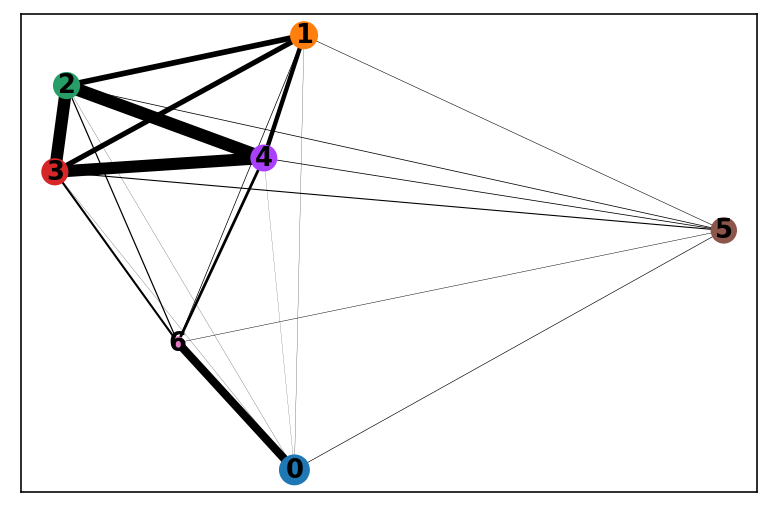

In [35]:
sc.tl.paga(adata, groups="leiden_scvi")
sc.pl.paga(adata, show=show_plot)

###  HeatMap

In [36]:
marker_genes = [
    "CD79A",
    "MS4A1",
    "LGALS3",
    "S100A8",
    "GNLY",
    "NKG7",
    "KLRB1",
    "FCGR3A",
    "FCER1A",
    "CST3",
    "PPBP",
]

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_scvi']`


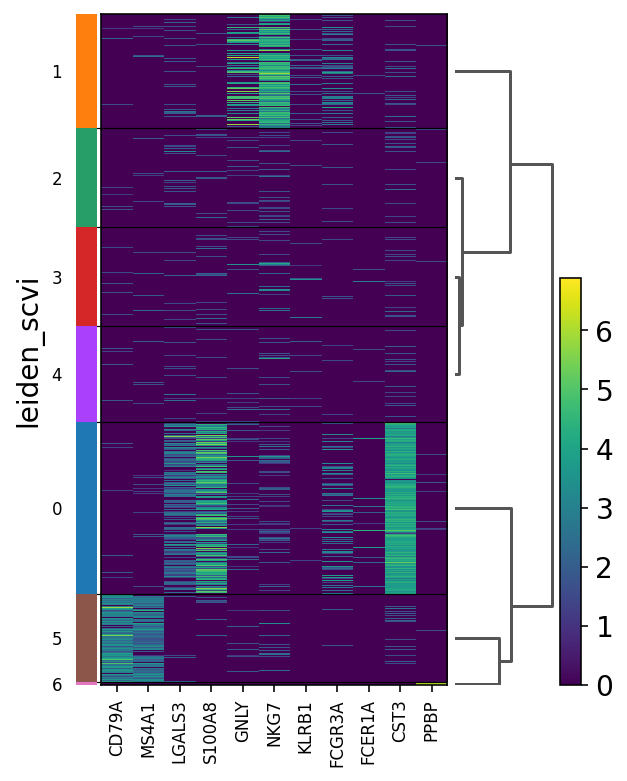

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 3.3, 1, 0.2])

In [37]:
sc.pl.heatmap(adata, marker_genes, groupby="leiden_scvi", dendrogram=True, show=show_plot)